In [61]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


In [62]:
# ! pip install tensorflow-gpu --ignore-installed

In [63]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

In [64]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows =10
pd.options.display.float_format = '{:.1f}'.format


In [65]:
cal_data=pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

cal_data=cal_data.reindex(np.random.permutation(cal_data.index))
cal_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


In [66]:
def preprocess_features(df):
    
    """
    Parameter:
        Dataframe 
    Return:
        Dataframe: with features only
    """
    
    selected_features = df[
            [
             'longitude',
             'latitude',
             'housing_median_age',
             'total_rooms',
             'total_bedrooms',
             'population',
             'households',
             'median_income',
            ]]
    
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (
        df["total_rooms"]/df["population"]
    )
        
    return processed_features

def preprocess_targets(df):
    """
    Parameter:
        Dataframe:
    Return:
        Datafreme with target values only
    """
    
    output_targets=pd.DataFrame()
    output_targets["median_house_value"] = (
        df["median_house_value"]/1000.0)
    
    return output_targets

### Depreciating this code for NN
* We can run it for feature crossing
* Using L2 regulariation
* It will be RawNBC convert

def get_quantile_based_boundaries(feature_values, num_buckets):
    boundaries = np.arange(1.0, num_buckets) / num_buckets
    quantiles =feature_values.quantile(boundaries)
    return [ quantiles[q] for q in quantiles.keys()
        ]


def construct_feature_columns():
    
    """
    Parameters:
        input_features: all the columns in feature
    Retrun: 
        All column of tf.numeric
    """

    
    households=tf.feature_column.numeric_column("households")
    longitude=tf.feature_column.numeric_column("longitude")
    latitude=tf.feature_column.numeric_column("latitude")
    
    
    bucketized_households = tf.feature_column.bucketized_column(
        households, 
        boundaries=get_quantile_based_boundaries(
            training_examples["households"], 7))

    bucketized_longitude=tf.feature_column.bucketized_column(
        longitude, 
        boundaries =get_quantile_based_boundaries(
            training_examples["longitude"],10)
        )  

    bucketized_latitude=tf.feature_column.bucketized_column(
        latitude, 
        boundaries =get_quantile_based_boundaries(
            training_examples["latitude"],10)
        )  

    # Crossimg columns here: 
    long_x_lat= tf.feature_column.crossed_column(
        set([bucketized_longitude, bucketized_latitude]), 
        hash_bucket_size=1000
        )
    
    # List of cols to return 
    
    feature_columns = set([
        bucketized_households,
        bucketized_longitude,
        bucketized_latitude,
        
        long_x_lat,
        ])  
    
#     return set([
#                 tf.feature_column.numeric_column(my_feature) 
#                 for my_feature in input_features
#                 ])
    return feature_columns   

In [ ]:
def contruct_input_feature(input_features):
    return set([
        tf.feature_column.numeric_column(my_feature)
        for my_feature in input_features 
        ])

In [68]:
training_examples   = preprocess_features(cal_data.head(12000))
training_targets    = preprocess_targets( cal_data.head(12000))
validation_examples = preprocess_features(cal_data.tail(5000))
validation_targets  = preprocess_targets( cal_data.tail(5000))

In [69]:
cal_data_cor=training_examples.copy()
cal_data_cor["target"]=training_targets["median_house_value"]
cal_data.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.0
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,-0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0
population,0.1,-0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.0
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,0.1
median_income,-0.0,-0.1,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.7
median_house_value,-0.0,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,1.0


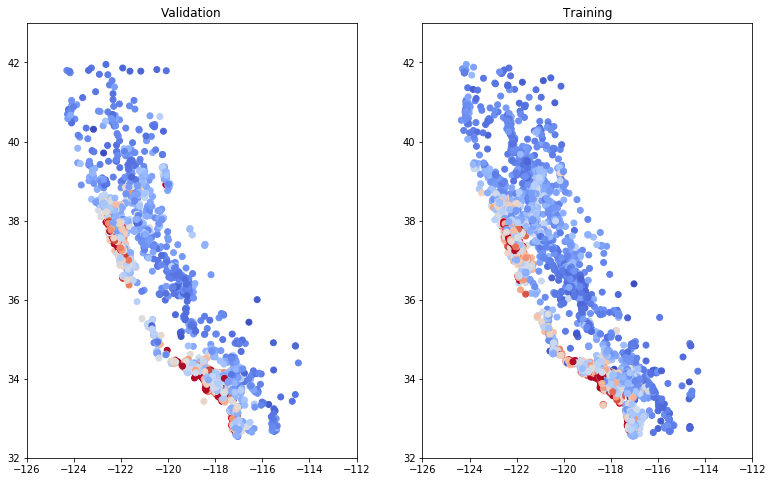

In [70]:
plt.figure(figsize=(13,8))

ax =plt.subplot(1,2,1)
ax.set_title("Validation")


ax.set_autoscaley_on(False)
ax.set_ylim([32,43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126,-112])

plt.scatter(
    validation_examples["longitude"],
    validation_examples["latitude"],
    cmap="coolwarm",
    c=validation_targets["median_house_value"] / training_targets["median_house_value"].max()
    )


ax =plt.subplot(1,2,2)
ax.set_title("Training")


ax.set_autoscaley_on(False)
ax.set_ylim([32,43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126,-112])

plt.scatter(
    training_examples["longitude"],
    training_examples["latitude"],
    cmap="coolwarm",
    c=training_targets["median_house_value"] / training_targets["median_house_value"].max()
    )

In [71]:
def my_input_fn(
    features, 
    targets, 
    batch_size=1, 
    shuffle=True, 
    num_epochs=None):
    
        """ Parameters: 
        features: pd dataframe of feature
        targets: pd dataframe of targets
        batch_size: size of batch
        shuffle shuffle data or not 
        num_epochs:  number of runs 
        
        Returns:
        Tuple of (features, lables) for next data batch
        """
        
        # Convert df into dict of np.array.
        features = { 
                    key:np.array(value) 
                    for key, value in dict(features).items() 
                   }
        
        #Contruct a dataset, and configure batching/repaeating.
        ds= Dataset.from_tensor_slices((features, targets))
        ds= ds.batch(batch_size).repeat(num_epochs)
        
        # Shuffle if ordered
        if shuffle:
            ds =ds.shuffle(10000)
            
        # Return next batch of the data
        features, labels =ds.make_one_shot_iterator().get_next()
        
        return features, labels

In [72]:
# https://stackoverflow.com/questions/42816124/steps-vs-num-epochs-in-tensorflow-getting-started-tutorial/42817280

def train_model(
    learning_rate, 
    steps, 
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    # How often you wnat updates:    
    periods =10 
    steps_per_period = steps/periods
    
    """ Parameters:
    learning_rate: how big should our step should be 
    steps: how many times should we process batch
    batch_size: sample size 
    input_feature: what should be the input 
    """
    
    #Configure regressor:
    my_optimizer= tf.train.FtrlOptimizer(learning_rate= learning_rate)
    my_optimizer= tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
        )
    
    # Creating input pfunction 
    
    training_input_fn = lambda: my_input_fn(
        training_examples,
        training_targets["median_house_value"],
        batch_size=batch_size)
    
    predict_training_input_fn = lambda: my_input_fn(
        training_examples,
        training_targets["median_house_value"],
        num_epochs=1,
        shuffle=False)
    
    predict_validation_input_fn = lambda: my_input_fn(
        validation_examples,
        validation_targets["median_house_value"],
        num_epochs=1,
        shuffle=False)
        

    # Trainign model from below code
    print "Training started:"
    print  "RMSE on models are:"
    training_rmses=[]
    validation_rmses=[]
    
    
    for  period in  range(0, periods):
        linear_regressor.train(
            input_fn = training_input_fn,
            steps = steps_per_period
            
        )
        
    
        # Take a break and and compute some predictions 
    
        training_predictions =linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([
                            item["predictions"][0]
                            for item in training_predictions 
                           ])
    
        validation_predictions =linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([
                            item["predictions"][0]
                            for item in validation_predictions 
                           ])
    
    
        # Compute loss
        training_mse=metrics.mean_squared_error(training_predictions, training_targets)
        training_rmse=math.sqrt( training_mse )
        
        validation_mse=metrics.mean_squared_error(validation_predictions, validation_targets)
        validation_rmse=math.sqrt( validation_mse )
        
        
        #Print current loss
        print "period %02d: %0.2f" % (period, training_rmse)
        
        #Save rmse
        training_rmses.append(training_rmse)
        validation_rmses.append(validation_rmse)
       
    print "Model training finished."
    
    # Output graph of loss metrics over periods. 
    plt.ylabel('RMSE')
    plt.xlabel("Periods")
    plt.title("RMSE vs Periods")
    plt.tight_layout()
    plt.plot(training_rmses, label="training")
    plt.plot(validation_rmses, label="validation")
    plt.legend()
  

    return linear_regressor

Training started:
RMSE on models are:
period 00: 190.73
period 01: 169.89
period 02: 155.07
period 03: 143.62
period 04: 134.48
period 05: 127.04
period 06: 120.97
period 07: 116.02
period 08: 111.92
period 09: 108.56
Model training finished.


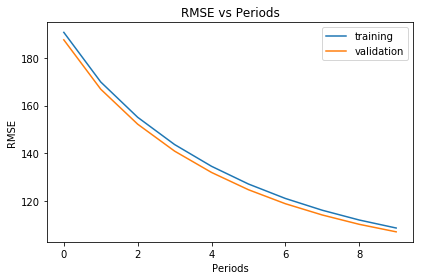

In [73]:
_=train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets
    )
 

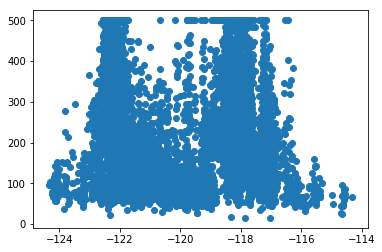

In [75]:
# plt.scatter(training_examples["median_income"], training_targets["median_house_value"])
plt.scatter(training_examples["longitude"], training_targets["median_house_value"])


In [ ]:
# https://stackoverflow.com/questions/25119524/pandas-conditional-rolling-count
    
    
#Set up plotting
#     plt.figure(figsize=(15,6))
#     plt.subplot(1,2,1)
#     plt.title(" Learnd line period")
#     plt.ylabel(my_label)
#     plt.xlabel(my_feature)
    
#     sample=df.sample(n=300)
#     plt.scatter(sample[my_feature], sample[my_label])
#     colors = [cm.coolwarm(x) 
#              for x in np.linspace(-1, 1, periods)
#              ]
    
    

#         # PLot weights and bias using graph 
#         y_extents=np.array([  0, sample[my_label].max()   ])

#         weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
#         bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

#         x_extents = (y_extents - bias) / weight
#         x_extents = np.maximum(np.minimum(x_extents,
#                                       sample[my_feature].max()),
#                            sample[my_feature].min())
#         y_extents = weight * x_extents + bias
#         plt.plot(x_extents, y_extents, color=colors[period]) 


def binner(df, col, kitni_bar_katu):
    max_of_col=df[col].max()
    min_of_col=df[col].min()
    range_of_col= max_of_col -min_of_col
    
    print "MAX:%0.2f" % (max_of_col)
    print "MIN:%0.2f" % (min_of_col)

    long_bin=[]
    for i in range(0, 12):
        long_bin.append(min_long)
        min_long +=1

pd.get_dummies(training_examples["longitude"])
pd.qcut(training_examples["longitude"], 10, labels=False)

# g=tf.one_hot(indices=training_examples["longitude"], depth=10,on_value=1, off_value=0 )
# g